# Preprocesamiento de Datos para Detección de Retinopatía Diabética

Este notebook contiene todo el pipeline de preprocesamiento de datos para el proyecto de detección de retinopatía diabética. Incluye:

- Reagrupación de clases de diagnóstico
- Análisis de resolución de imágenes
- Conversión de formato PNG a JPG
- Técnicas de preprocesamiento de imágenes
- División del conjunto de datos
- Organización estructurada de datos
- Balanceo de clases mediante aumento de datos

---

## 📚 Importación de Librerías

Comenzamos importando las librerías necesarias para el análisis y manipulación de datos.

In [ ]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import random
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import shutil

## Reagrupación de clases

---

En esta sección realizamos la reagrupación de las clases de diagnóstico para simplificar el problema de clasificación. Reducimos las 5 clases originales a 3 clases más manejables:

- **Clase 0**: Sin retinopatía diabética (original: 0)
- **Clase 1**: Retinopatía diabética leve (original: 1, 2)  
- **Clase 2**: Retinopatía diabética severa (original: 3, 4)

### Carga de etiquetas originales

In [2]:
labels = pd.read_csv("../data/original/labels.csv")

### Distribución original de clases

In [ ]:
labels['diagnosis'].value_counts()

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

### Aplicación del mapeo de clases

In [ ]:
labels['diagnosis'] = labels['diagnosis'].map({0:0, 1:1, 2:1, 3:2, 4:2})

### Distribución después de la reagrupación

In [ ]:
labels['diagnosis'].value_counts()

diagnosis
0    1805
1    1369
2     488
Name: count, dtype: int64

### Guardado de etiquetas procesadas

In [ ]:
labels.to_csv("../data/processed/labels.csv", index=False)

## Resolución de las imágenes

---

En esta sección analizamos las dimensiones de las imágenes originales para entender la distribución de resoluciones y determinar el tamaño óptimo para el redimensionamiento.

### Recolección de dimensiones de imágenes

In [ ]:
images_path = "../data/original/data/"

widths, heights= [], []

for filename in os.listdir(images_path):
    if filename.endswith('.png'):
        img_path = os.path.join(images_path, filename)
        image = cv2.imread(img_path)
        if image is not None:
            h, w = image.shape[:2]
            widths.append(w)
            heights.append(h)

### Visualización de la distribución de dimensiones

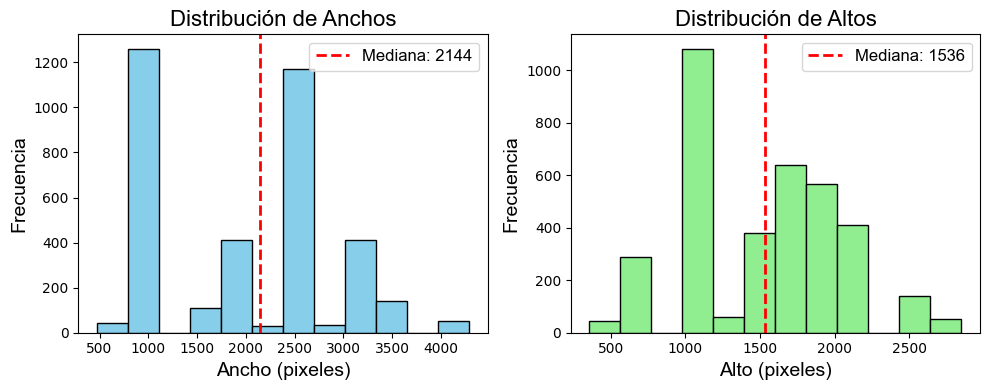

In [ ]:
median_width = np.median(widths)
median_height = np.median(heights)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=12, color='skyblue', edgecolor='black')
plt.axvline(median_width, color='red', linestyle='dashed', linewidth=2, label=f'Mediana: {int(median_width)}')
plt.title('Distribución de Anchos', fontname='Arial', fontsize=16)
plt.xlabel('Ancho (pixeles)', fontname='Arial', fontsize=14)
plt.ylabel('Frecuencia', fontname='Arial', fontsize=14)
plt.legend(prop={'family': 'Arial', 'size': 12})

plt.subplot(1, 2, 2)
plt.hist(heights, bins=12, color='lightgreen', edgecolor='black')
plt.axvline(median_height, color='red', linestyle='dashed', linewidth=2, label=f'Mediana: {int(median_height)}')
plt.title('Distribución de Altos', fontname='Arial', fontsize=16)
plt.xlabel('Alto (pixeles)', fontname='Arial', fontsize=14)
plt.ylabel('Frecuencia', fontname='Arial', fontsize=14)
plt.legend(prop={'family': 'Arial', 'size': 12})

plt.tight_layout()
plt.show()

## Transformar PNG -> JPG

---

Convertimos las imágenes de formato PNG a JPG para reducir el tamaño de archivo manteniendo la calidad visual. Esto optimiza el almacenamiento y acelera el procesamiento posterior.

### Función de conversión PNG a JPG

La función utiliza una calidad del 95% para mantener la máxima fidelidad visual mientras reduce el tamaño del archivo.

In [ ]:
def transform_png2jpg(src_root, dst_root, quality=95):
    os.makedirs(dst_root, exist_ok=True)
    files = os.listdir(src_root)
    for file in files:
        root_png = os.path.join(src_root, file)
        root = os.path.splitext(file)[0]
        root_jpg = os.path.join(dst_root, f"{root}.jpg")
        image = cv2.imread(root_png)
        if image is None:
            print(f"Could not read {root_png}, skipping...")
            continue
        cv2.imwrite(root_jpg, image, [int(cv2.IMWRITE_JPEG_QUALITY), quality])

### Ejecución de la conversión

In [2]:
transform_png2jpg('../data/original/images/', '../data/processed/images-jpg/', quality=95)

## Preprocesamiento de imágenes

---

## 🖼️ Pipeline de Preprocesamiento de Imágenes

Esta sección implementa un pipeline completo de preprocesamiento que incluye tres etapas principales:

1. **Recorte centrado**: Elimina bordes negros y enfoca la región de interés (retina)
2. **Realce de contraste**: Mejora la visibilidad de estructuras mediante CLAHE
3. **Eliminación de ruido**: Aplica filtro bilateral para suavizar el ruido preservando bordes

Cada etapa se aplica secuencialmente para optimizar la calidad de las imágenes para el entrenamiento.

### 1. Recorte centrado

El recorte centrado elimina los bordes negros de las imágenes retinianas y se enfoca en la región de interés. Utiliza detección de contornos para identificar automáticamente el área de la retina.

In [ ]:
def crop_center_retina(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(
        thresh, 
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    if not contours:
        return img
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    return img[y:y+h, x:x+w]

def crop_all_images_in_folder(folder_path, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".jpg"):
            input_path = os.path.join(folder_path, filename)
            img = cv2.imread(input_path)
            cropped = crop_center_retina(img)
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, cropped, [cv2.IMWRITE_JPEG_QUALITY, 95])

#### Aplicación del recorte centrado

In [6]:
crop_all_images_in_folder('../data/processed/versionB/', '../data/processed/versionB-cropped/')

### 2. Realce de contraste

El realce de contraste mediante CLAHE (Contrast Limited Adaptive Histogram Equalization) mejora la visibilidad de las estructuras retinianas al trabajar en el canal L del espacio de color LAB, preservando la información de color original.

In [ ]:
def apply_clahe_l_channel(img):
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    img_lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe_bgr = cv2.cvtColor(img_lab_clahe, cv2.COLOR_LAB2BGR)
    return img_clahe_bgr

def apply_clahe_to_folder(folder_path, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".jpg"):
            input_path = os.path.join(folder_path, filename)
            img = cv2.imread(input_path)
            clahe_img = apply_clahe_l_channel(img)
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, clahe_img, [cv2.IMWRITE_JPEG_QUALITY, 95])

#### Aplicación de CLAHE

In [9]:
apply_clahe_to_folder('../data/processed/versionB-cropped/', '../data/processed/versionB-clahe/')

### 3. Eliminación de ruido (Filtro Bilateral)

El filtro bilateral reduce el ruido de la imagen mientras preserva los bordes importantes. Es especialmente útil para imágenes médicas donde es crucial mantener la definición de las estructuras anatómicas.

In [10]:
import cv2
import os

def apply_bilateral_filter(img):
    return cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

def apply_filter_to_folder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(".jpg"):
            input_path = os.path.join(input_folder, filename)
            img = cv2.imread(input_path)
            filtered = apply_bilateral_filter(img)
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, filtered, [cv2.IMWRITE_JPEG_QUALITY, 95])

#### Aplicación del filtro bilateral

In [ ]:
apply_filter_to_folder('../data/processed/versionB-clahe/', '../data/processed/versionB-bilateral/')

## Configuración del entorno de entrenamiento

---

## ⚙️ Configuración del Entorno de Entrenamiento

Esta sección establece la configuración necesaria para garantizar la reproducibilidad de los experimentos.

### Función de configuración de semillas

Esta función garantiza que todos los experimentos sean reproducibles al fijar las semillas aleatorias de todas las librerías utilizadas.

In [ ]:
RANDOM_SEED = 42
os.environ.setdefault("PYTHONHASHSEED", str(RANDOM_SEED))
os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":16:8")

def set_seed(seed: int = RANDOM_SEED, deterministic: bool = True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    torch.use_deterministic_algorithms(deterministic)
    torch.backends.cudnn.deterministic = deterministic
    torch.backends.cudnn.benchmark = not deterministic

    g = torch.Generator().manual_seed(seed)
    def _worker_init_fn(worker_id):
        s = seed + worker_id
        random.seed(s)
        np.random.seed(s)
        torch.manual_seed(s)
    return g, _worker_init_fn

---

## 📊 División del Conjunto de Datos

Se realiza una división estratificada del dataset en tres conjuntos:

- **Entrenamiento**: 60% de los datos
- **Validación**: 20% de los datos  
- **Prueba**: 20% de los datos

La estratificación asegura que cada conjunto mantenga la misma proporción de clases que el dataset original.

### Proceso de división estratificada

In [ ]:
labels = pd.read_csv('../data/processed/labels.csv')

x_train, x_test, y_train, y_test = train_test_split(
    labels['id_code'], labels['diagnosis'], train_size = 0.6,
    stratify = labels['diagnosis'], random_state = RANDOM_SEED
)

x_test, x_val, y_test, y_val = train_test_split(
    x_test, y_test, test_size = 0.5,
    stratify = y_test, random_state = RANDOM_SEED
)

train_labels = pd.DataFrame({'id_code': x_train, 'diagnosis': y_train})
test_labels = pd.DataFrame({'id_code': x_test, 'diagnosis': y_test})
val_labels = pd.DataFrame({'id_code': x_val, 'diagnosis': y_val})

---

## 📁 Organización Estructurada de Datos

Se organiza el dataset en una estructura de carpetas compatible con PyTorch ImageFolder:

```
data/structured/versionB/
├── train/
│   ├── 0/
│   ├── 1/
│   └── 2/
├── val/
│   ├── 0/
│   ├── 1/
│   └── 2/
└── test/
    ├── 0/
    ├── 1/
    └── 2/
```

Esta estructura facilita la carga de datos durante el entrenamiento.

### Función de organización de datasets

In [ ]:
def organize_dataset(df, split_type, src_root, dst_root):
    for _, row in df.iterrows():
        img_name = row['id_code'] + '.jpg'
        label = str(row['diagnosis'])
        source = os.path.join(src_root, img_name)
        dst_dir = os.path.join(dst_root, split_type, label)
        os.makedirs(dst_dir, exist_ok=True)
        dest = os.path.join(dst_dir, img_name)
        shutil.copy2(source, dest)

### Ejecución de la organización

In [ ]:
organize_dataset(train_labels, 'train', '../data/processed/versionB-bilateral', '../data/structured/versionB')
organize_dataset(val_labels, 'val', '../data/processed/versionB-bilateral', '../data/structured/versionB')
organize_dataset(test_labels, 'test', '../data/processed/versionB-bilateral', '../data/structured/versionB')

---

## ⚖️ Aumento de Datos y Balanceo de Clases

Para abordar el desbalance de clases en el dataset, se aplican técnicas de aumento de datos (data augmentation) que generan variaciones sintéticas de las imágenes existentes. 

Las transformaciones incluyen:
- **Rotación aleatoria**: ±5 grados
- **Escalado**: 95% - 110% del tamaño original
- **Ajuste de color**: Brillo y contraste

El objetivo es equilibrar todas las clases a 1100 imágenes cada una en el conjunto de entrenamiento.

### Pipeline de transformaciones para aumento de datos

In [ ]:
augment = transforms.Compose([
    transforms.RandomRotation(degrees=5, fill=0),
    transforms.RandomAffine(degrees=0, scale=(0.95, 1.10), fill=0),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
])

def data_balancing_torch(input_dir: str, output_dir: str, n_images: int):
    os.makedirs(output_dir, exist_ok=True)
    images = sorted(os.listdir(input_dir))

    i = 0
    while i < n_images - len(images):
        img_name = images[i % len(images)]
        img_path = os.path.join(input_dir, img_name)

        img = Image.open(img_path).convert("RGB")
        aug_img = augment(img)

        save_name = f"aug_{i}_{img_name}"
        save_path = os.path.join(output_dir, save_name)
        aug_img.save(save_path, quality=95)
        i += 1

### Copia del dataset estructurado

Se crea una copia del dataset estructurado para aplicar el balanceo sin afectar la versión original.

In [ ]:
shutil.copytree('../data/structured', '../data/structured-balanced')

'../data/structured-balanced'

### Aplicación del balanceo de clases

Se aplica el aumento de datos a cada clase del conjunto de entrenamiento para equilibrar todas las clases a 1100 imágenes.

In [ ]:
set_seed(RANDOM_SEED, deterministic=True)

data_balancing_torch('../data/structured-balanced/versionB/train/0', '../data/structured-balanced/versionB/train/0', 1100)
data_balancing_torch('../data/structured-balanced/versionB/train/1', '../data/structured-balanced/versionB/train/1', 1100)
data_balancing_torch('../data/structured-balanced/versionB/train/2', '../data/structured-balanced/versionB/train/2', 1100)

---

## ✅ Resumen del Preprocesamiento

Al finalizar este notebook, se han completado las siguientes tareas:

1. **✓ Reagrupación de clases**: De 5 clases originales a 3 clases balanceadas
2. **✓ Análisis de resolución**: Identificación de las dimensiones típicas de las imágenes
3. **✓ Conversión de formato**: PNG → JPG para optimización de almacenamiento
4. **✓ Pipeline de preprocesamiento**:
   - Recorte centrado automático
   - Realce de contraste con CLAHE
   - Reducción de ruido con filtro bilateral
5. **✓ División estratificada**: 60% entrenamiento, 20% validación, 20% prueba
6. **✓ Organización estructurada**: Compatible con PyTorch ImageFolder
7. **✓ Balanceo de clases**: 1100 imágenes por clase en entrenamiento

### 📁 Estructura final de datos:

```
data/
├── structured-balanced/versionB/     # Dataset balanceado y listo para entrenamiento
│   ├── train/                       # 3300 imágenes (1100 por clase)
│   ├── val/                         # Conjunto de validación
│   └── test/                        # Conjunto de prueba
└── structured/versionB/              # Dataset sin balancear (respaldo)
```

**El dataset está ahora listo para el entrenamiento de modelos de deep learning.**